In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data preprocessing

In [ ]:
#fxn to merge necessary cols for each aeronet ground station
import pandas as pd

def merge_req(site_name):
    #read
    eaod = pd.read_csv(f"/content/drive/MyDrive/aerosol/data3sites/{site_name}_eaod.csv")
    ssa = pd.read_csv(f"/content/drive/MyDrive/aerosol/data3sites/{site_name}_ssa.csv")
    aaod = pd.read_csv(f"/content/drive/MyDrive/aerosol/data3sites/{site_name}_aaod.csv")
    ri = pd.read_csv(f"/content/drive/MyDrive/aerosol/data3sites/{site_name}_ri.csv")

    #extracting  req cols
    aerosol = eaod.iloc[:, 0:18]
    ssa_selected = ssa[['Single_Scattering_Albedo[440nm]', 'Single_Scattering_Albedo[675nm]',
                         'Single_Scattering_Albedo[870nm]', 'Single_Scattering_Albedo[1020nm]']]
    aaod_selected = aaod[['Absorption_AOD[440nm]', 'Absorption_AOD[675nm]', 'Absorption_AOD[870nm]',
                           'Absorption_AOD[1020nm]', 'Absorption_Angstrom_Exponent_440-870nm']]
    ri_selected = ri[['Refractive_Index-Real_Part[440nm]', 'Refractive_Index-Real_Part[675nm]',
                      'Refractive_Index-Real_Part[870nm]', 'Refractive_Index-Real_Part[1020nm]',
                      'Refractive_Index-Imaginary_Part[440nm]', 'Refractive_Index-Imaginary_Part[675nm]',
                      'Refractive_Index-Imaginary_Part[870nm]', 'Refractive_Index-Imaginary_Part[1020nm]']]

    #merge
    df = aerosol.merge(ssa_selected, left_index=True, right_index=True)
    df = df.merge(aaod_selected, left_index=True, right_index=True)
    df = df.merge(ri_selected, left_index=True, right_index=True)

    return df

In [ ]:
# seperate df for each site
kanpur_para = merge_req("kanpur")
iitdelhi_para = merge_req("iitdelhi")
pune_para = merge_req("pune")

In [ ]:
# concating data from all sites
aerosol = pd.concat([kanpur_para, iitdelhi_para, pune_para], ignore_index=True)

# EDA Before


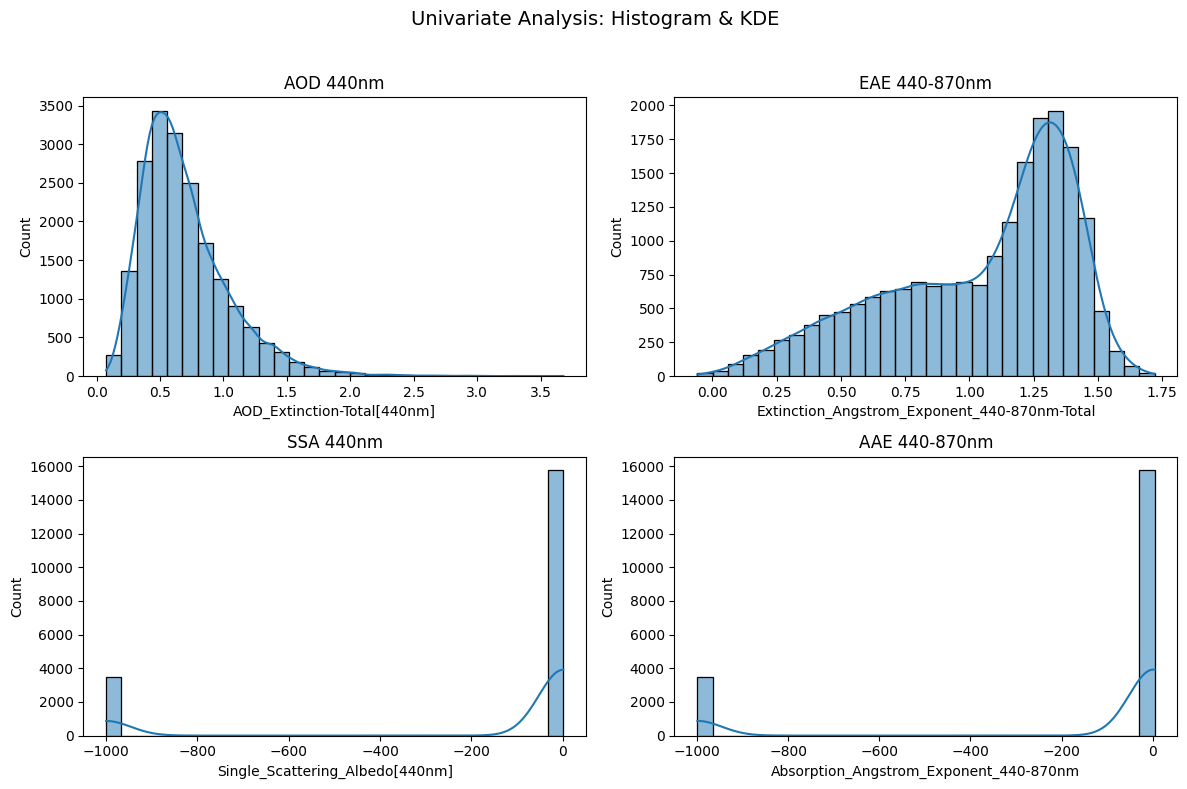

In [ ]:
#kde and hist
col_titles = {
    "AOD_Extinction-Total[440nm]": "AOD 440nm",
    "Extinction_Angstrom_Exponent_440-870nm-Total": "EAE 440-870nm",
    "Single_Scattering_Albedo[440nm]": "SSA 440nm",
    "Absorption_Angstrom_Exponent_440-870nm": "AAE 440-870nm"
}

uni = list(col_titles.keys())

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle("Univariate Analysis: Histogram & KDE", fontsize=14)

for idx, col in enumerate(uni):
    ax = axes[idx // 2, idx % 2]
    sns.histplot(aerosol[col], kde=True, bins=30, ax=ax)
    ax.set_title(col_titles[col])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

1. The AOD (Aerosol Optical Depth) at 440nm shows a right-skewed distribution with peak values between 0.5-0.7, indicating most measurements capture relatively low-to-moderate aerosol loading.
2. The EAE (Extinction Ångström Exponent) for 440-870nm exhibits a bimodal distribution with peaks around 0.5-0.75 and 1.25-1.5, suggesting the presence of both fine and coarse aerosol particle populations.
3. Both SSA (Single Scattering Albedo) at 440nm and AAE (Absorption Ångström Exponent) histograms display extremely large spikes at -999, representing missing values or NaN entries in the dataset.
4. The secondary peaks for both SSA and AAE (at approximately -950 to -999) have counts around 3,000-4,000, showing a significant portion of the dataset contains these placeholder values rather than actual measurements.
5. The KDE curves attempt to smooth the distributions but are heavily influenced by the -999 values in the bottom two plots, making proper distribution analysis of the actual SSA and AAE measurements difficult without filtering out these placeholder values.

<Figure size 1200x600 with 0 Axes>

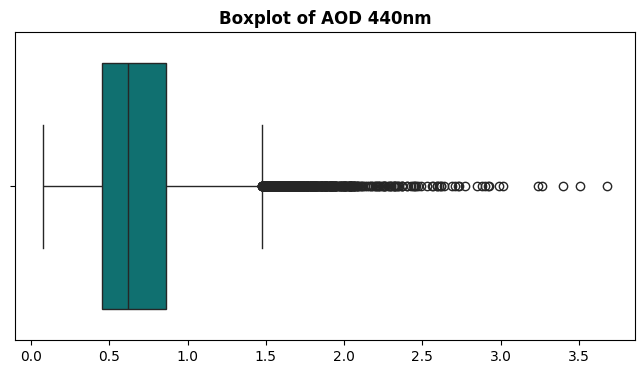

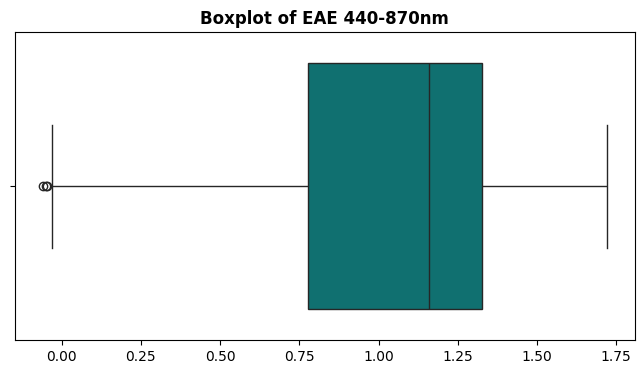

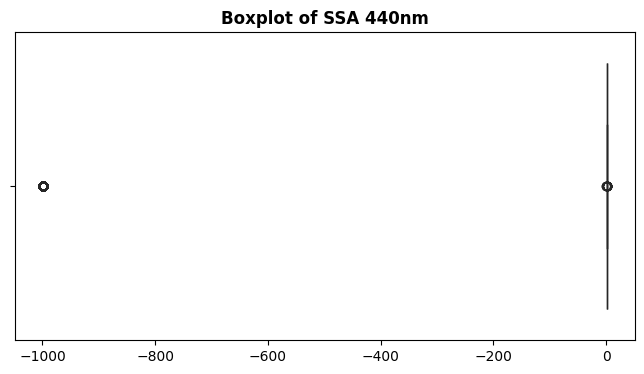

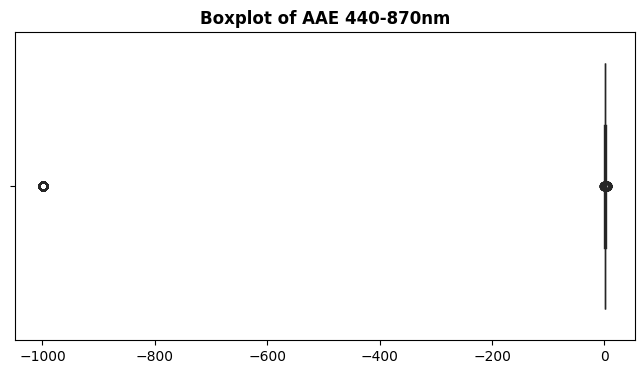

In [ ]:
#box plot
selected_cols = ["AOD_Extinction-Total[440nm]", "Extinction_Angstrom_Exponent_440-870nm-Total",
                 "Single_Scattering_Albedo[440nm]", "Absorption_Angstrom_Exponent_440-870nm"]

titles = ["AOD 440nm", "EAE 440-870nm", "SSA 440nm", "AAE 440-870nm"]

plt.figure(figsize=(12, 6))
plt.suptitle("Univariate Analysis: Boxplots", fontsize=14, fontweight="bold", color="darkblue")

for col, title in zip(selected_cols, titles):
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=aerosol[col], color="teal")
    plt.title(f"Boxplot of {title}", fontsize=12, fontweight="bold")
    plt.xlabel("")
    plt.show()

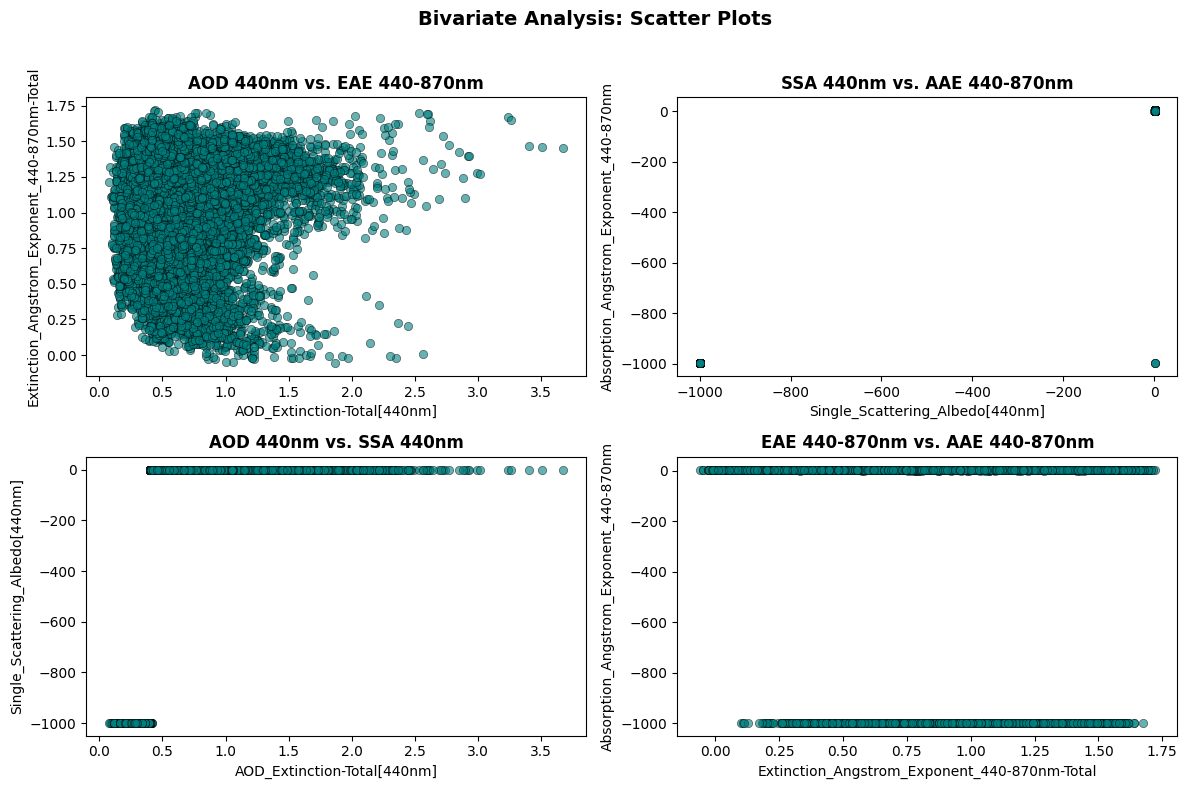

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle("Bivariate Analysis: Scatter Plots", fontsize=14, fontweight="bold")

bivariate_pairs = [
    ("AOD_Extinction-Total[440nm]", "Extinction_Angstrom_Exponent_440-870nm-Total"),
    ("Single_Scattering_Albedo[440nm]", "Absorption_Angstrom_Exponent_440-870nm"),
    ("AOD_Extinction-Total[440nm]", "Single_Scattering_Albedo[440nm]"),
    ("Extinction_Angstrom_Exponent_440-870nm-Total", "Absorption_Angstrom_Exponent_440-870nm")
]

titles = [
    "AOD 440nm vs. EAE 440-870nm",
    "SSA 440nm vs. AAE 440-870nm",
    "AOD 440nm vs. SSA 440nm",
    "EAE 440-870nm vs. AAE 440-870nm"
]

for idx, ((x_col, y_col), title) in enumerate(zip(bivariate_pairs, titles)):
    ax = axes[idx // 2, idx % 2]
    sns.scatterplot(data=aerosol, x=x_col, y=y_col, alpha=0.6, color="teal", edgecolor="black", ax=ax)
    ax.set_title(title, fontsize=12, fontweight="bold", color="black")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


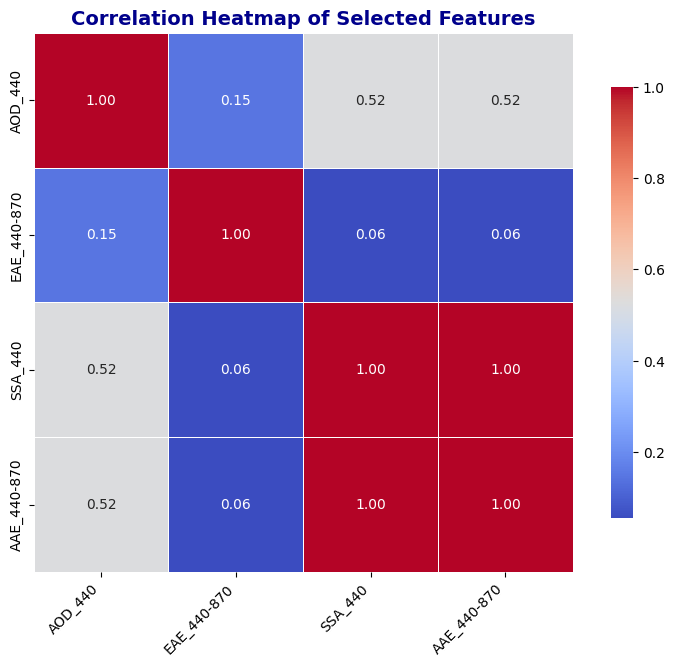

In [ ]:
#correlation heatmap
short_labels = {
    "AOD_Extinction-Total[440nm]": "AOD_440",
    "Extinction_Angstrom_Exponent_440-870nm-Total": "EAE_440-870",
    "Single_Scattering_Albedo[440nm]": "SSA_440",
    "Absorption_Angstrom_Exponent_440-870nm": "AAE_440-870"
}

corr_data = aerosol[selected_cols].rename(columns=short_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(corr_data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, square=True, cbar_kws={'shrink': 0.8})
plt.title("Correlation Heatmap of Selected Features", fontsize=14, fontweight="bold", color="darkblue")
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.show()


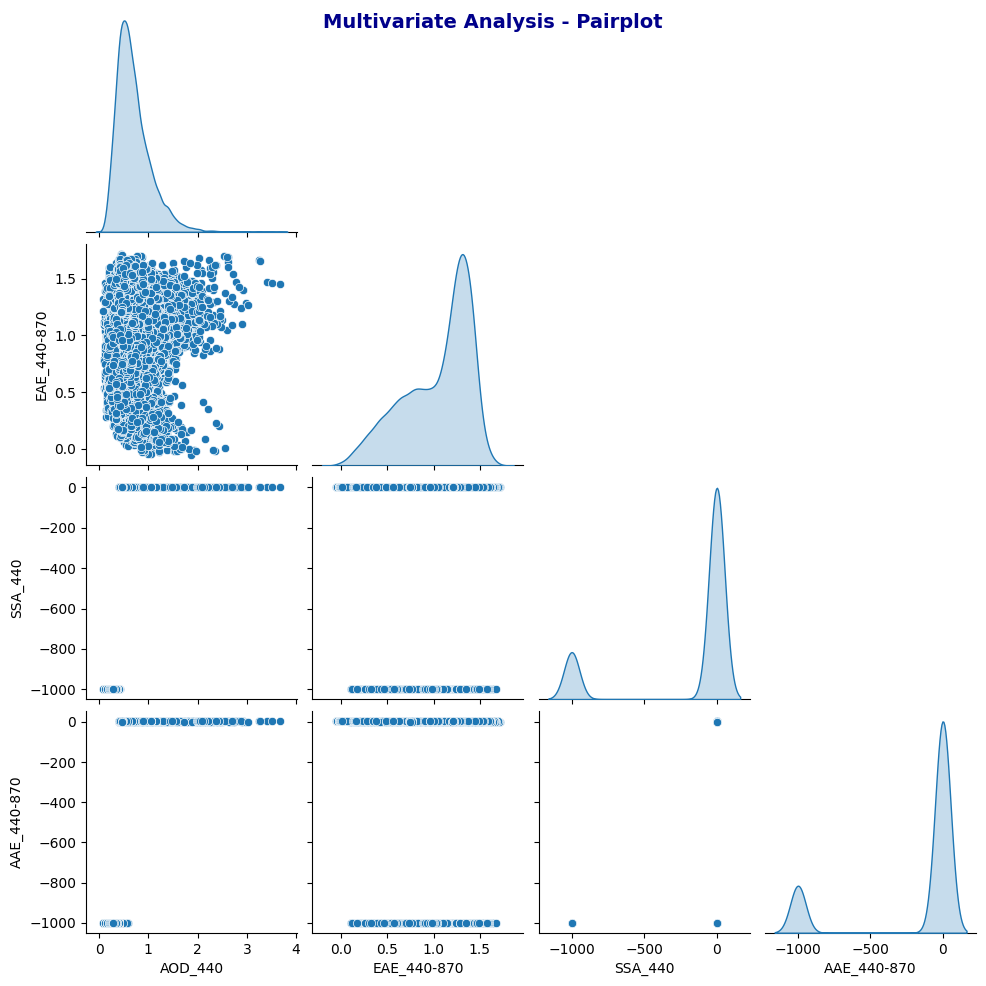

In [ ]:
# pairplot
#corr_data = aerosol[univariate_cols].rename(columns=short_labels)
pairplot = sns.pairplot(corr_data, diag_kind="kde", corner=True)
pairplot.fig.suptitle("Multivariate Analysis - Pairplot", fontsize=14, fontweight="bold", color="darkblue")

plt.show()

# Handling Missing Data


In [ ]:
aerosol.replace(-999, np.nan, inplace=True)
aerosol.isnull().mean()*100

Site                                             0.000000
Date(dd:mm:yyyy)                                 0.000000
Time(hh:mm:ss)                                   0.000000
Day_of_Year                                      0.000000
Day_of_Year(Fraction)                            0.000000
AOD_Extinction-Total[440nm]                      0.000000
AOD_Extinction-Total[675nm]                      0.000000
AOD_Extinction-Total[870nm]                      0.000000
AOD_Extinction-Total[1020nm]                     0.000000
AOD_Extinction-Fine[440nm]                       0.000000
AOD_Extinction-Fine[675nm]                       0.000000
AOD_Extinction-Fine[870nm]                       0.000000
AOD_Extinction-Fine[1020nm]                      0.000000
AOD_Extinction-Coarse[440nm]                     0.000000
AOD_Extinction-Coarse[675nm]                     0.000000
AOD_Extinction-Coarse[870nm]                     0.000000
AOD_Extinction-Coarse[1020nm]                    0.000000
Extinction_Angstrom_Exponent_440-870nm-Total     0.000000
Single_Scattering_Albedo[440nm]                 18.181818
Single_Scattering_Albedo[675nm]                 18.181818
Single_Scattering_Albedo[870nm]                 18.181818
Single_Scattering_Albedo[1020nm]                18.181818
Absorption_AOD[440nm]                           18.181818
Absorption_AOD[675nm]                           18.181818
Absorption_AOD[870nm]                           18.181818
Absorption_AOD[1020nm]                          18.181818
Absorption_Angstrom_Exponent_440-870nm          18.197385
Refractive_Index-Real_Part[440nm]               18.181818
Refractive_Index-Real_Part[675nm]               18.181818
Refractive_Index-Real_Part[870nm]               18.181818
Refractive_Index-Real_Part[1020nm]              18.181818
Refractive_Index-Imaginary_Part[440nm]          18.181818
Refractive_Index-Imaginary_Part[675nm]          18.181818
Refractive_Index-Imaginary_Part[870nm]          18.181818
Refractive_Index-Imaginary_Part[1020nm]         18.181818
dtype: float64

In [ ]:
cols_to_interpolate = ["Single_Scattering_Albedo[440nm]", "Single_Scattering_Albedo[675nm]",
                        "Single_Scattering_Albedo[870nm]", "Single_Scattering_Albedo[1020nm]",
                        "Absorption_AOD[440nm]", "Absorption_AOD[675nm]", "Absorption_AOD[870nm]",
                        "Absorption_AOD[1020nm]", "Absorption_Angstrom_Exponent_440-870nm",
                        "Refractive_Index-Real_Part[440nm]", "Refractive_Index-Real_Part[675nm]",
                        "Refractive_Index-Real_Part[870nm]", "Refractive_Index-Real_Part[1020nm]",
                        "Refractive_Index-Imaginary_Part[440nm]", "Refractive_Index-Imaginary_Part[675nm]",
                        "Refractive_Index-Imaginary_Part[870nm]", "Refractive_Index-Imaginary_Part[1020nm]"]


aerosol[cols_to_interpolate] = aerosol[cols_to_interpolate].interpolate(method='linear')


In [ ]:
aerosol.isnull().sum()

Site                                            0
Date(dd:mm:yyyy)                                0
Time(hh:mm:ss)                                  0
Day_of_Year                                     0
Day_of_Year(Fraction)                           0
AOD_Extinction-Total[440nm]                     0
AOD_Extinction-Total[675nm]                     0
AOD_Extinction-Total[870nm]                     0
AOD_Extinction-Total[1020nm]                    0
AOD_Extinction-Fine[440nm]                      0
AOD_Extinction-Fine[675nm]                      0
AOD_Extinction-Fine[870nm]                      0
AOD_Extinction-Fine[1020nm]                     0
AOD_Extinction-Coarse[440nm]                    0
AOD_Extinction-Coarse[675nm]                    0
AOD_Extinction-Coarse[870nm]                    0
AOD_Extinction-Coarse[1020nm]                   0
Extinction_Angstrom_Exponent_440-870nm-Total    0
Single_Scattering_Albedo[440nm]                 0
Single_Scattering_Albedo[675nm]                 0
Single_Scattering_Albedo[870nm]                 0
Single_Scattering_Albedo[1020nm]                0
Absorption_AOD[440nm]                           0
Absorption_AOD[675nm]                           0
Absorption_AOD[870nm]                           0
Absorption_AOD[1020nm]                          0
Absorption_Angstrom_Exponent_440-870nm          0
Refractive_Index-Real_Part[440nm]               0
Refractive_Index-Real_Part[675nm]               0
Refractive_Index-Real_Part[870nm]               0
Refractive_Index-Real_Part[1020nm]              0
Refractive_Index-Imaginary_Part[440nm]          0
Refractive_Index-Imaginary_Part[675nm]          0
Refractive_Index-Imaginary_Part[870nm]          0
Refractive_Index-Imaginary_Part[1020nm]         0
dtype: int64

# EDA After


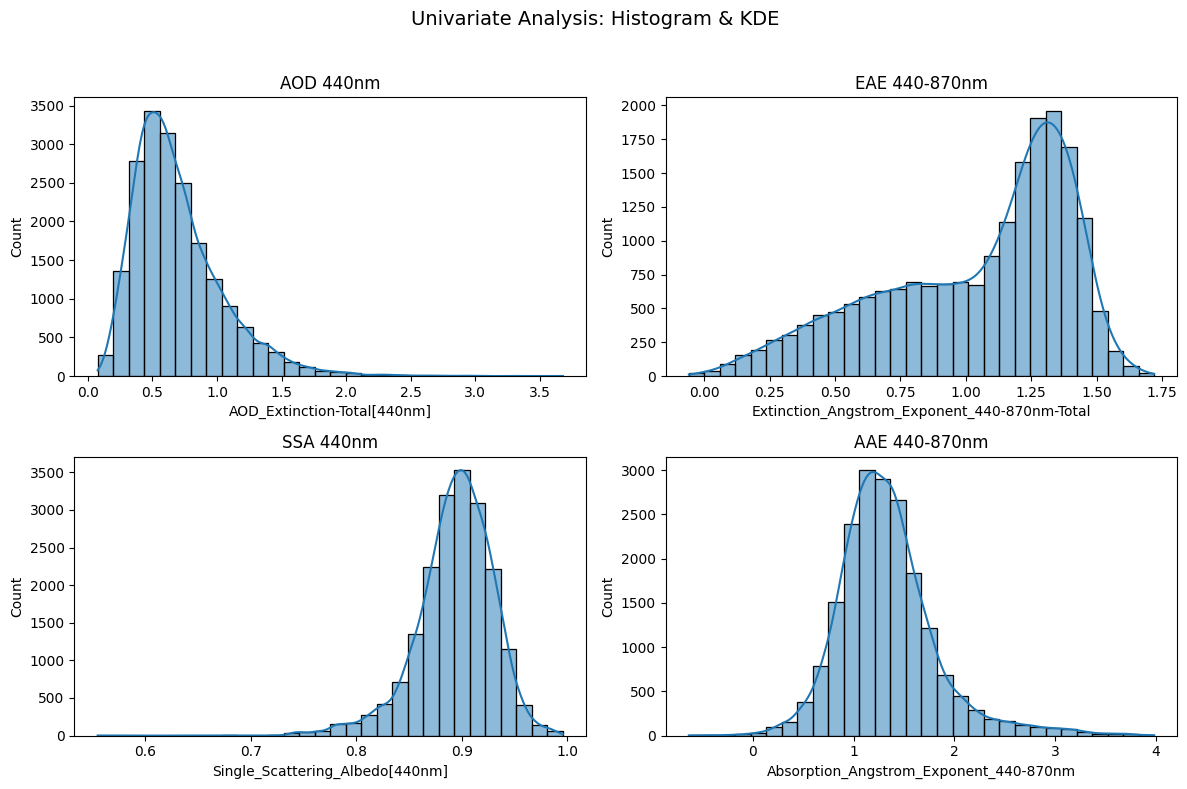

In [ ]:
#kde and hist
col_titles = {
    "AOD_Extinction-Total[440nm]": "AOD 440nm",
    "Extinction_Angstrom_Exponent_440-870nm-Total": "EAE 440-870nm",
    "Single_Scattering_Albedo[440nm]": "SSA 440nm",
    "Absorption_Angstrom_Exponent_440-870nm": "AAE 440-870nm"
}

uni = list(col_titles.keys())

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle("Univariate Analysis: Histogram & KDE", fontsize=14)

for idx, col in enumerate(uni):
    ax = axes[idx // 2, idx % 2]
    sns.histplot(aerosol[col], kde=True, bins=30, ax=ax)
    ax.set_title(col_titles[col])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<Figure size 1200x600 with 0 Axes>

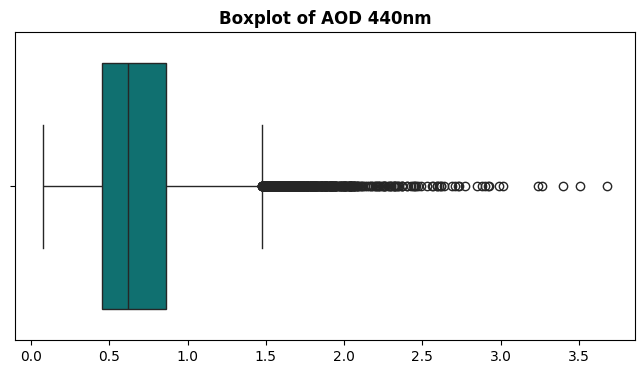

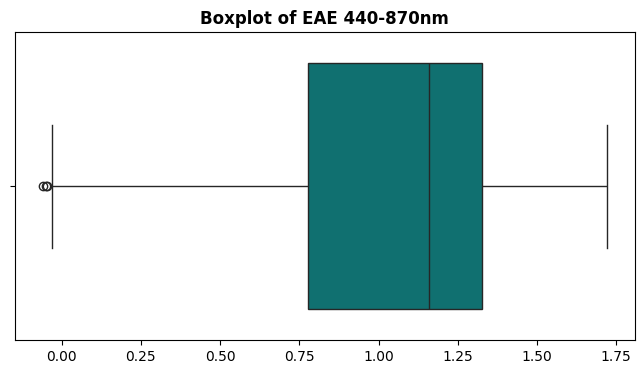

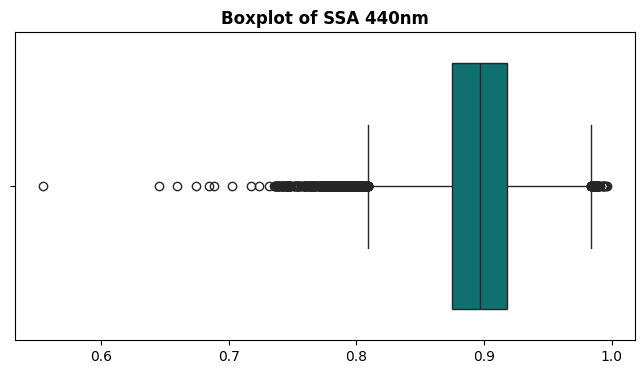

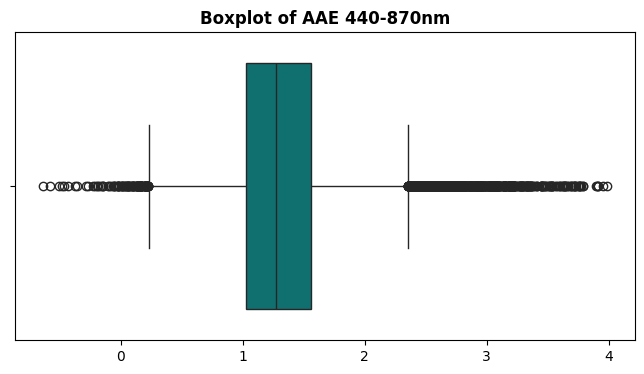

In [ ]:
#box plot
selected_cols = ["AOD_Extinction-Total[440nm]", "Extinction_Angstrom_Exponent_440-870nm-Total",
                 "Single_Scattering_Albedo[440nm]", "Absorption_Angstrom_Exponent_440-870nm"]

titles = ["AOD 440nm", "EAE 440-870nm", "SSA 440nm", "AAE 440-870nm"]

plt.figure(figsize=(12, 6))
plt.suptitle("Univariate Analysis: Boxplots", fontsize=14, fontweight="bold", color="darkblue")

for col, title in zip(selected_cols, titles):
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=aerosol[col], color="teal")
    plt.title(f"Boxplot of {title}", fontsize=12, fontweight="bold")
    plt.xlabel("")
    plt.show()

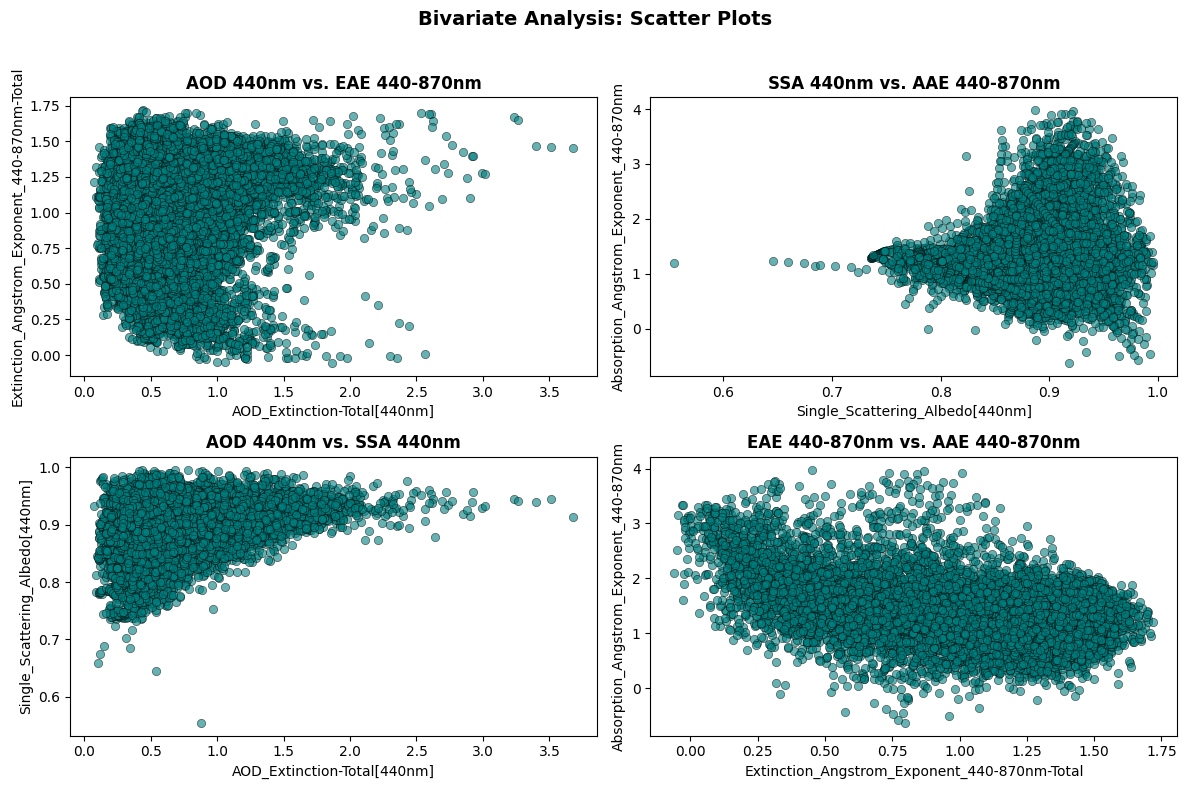

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle("Bivariate Analysis: Scatter Plots", fontsize=14, fontweight="bold")

bivariate_pairs = [
    ("AOD_Extinction-Total[440nm]", "Extinction_Angstrom_Exponent_440-870nm-Total"),
    ("Single_Scattering_Albedo[440nm]", "Absorption_Angstrom_Exponent_440-870nm"),
    ("AOD_Extinction-Total[440nm]", "Single_Scattering_Albedo[440nm]"),
    ("Extinction_Angstrom_Exponent_440-870nm-Total", "Absorption_Angstrom_Exponent_440-870nm")
]

titles = [
    "AOD 440nm vs. EAE 440-870nm",
    "SSA 440nm vs. AAE 440-870nm",
    "AOD 440nm vs. SSA 440nm",
    "EAE 440-870nm vs. AAE 440-870nm"
]

for idx, ((x_col, y_col), title) in enumerate(zip(bivariate_pairs, titles)):
    ax = axes[idx // 2, idx % 2]
    sns.scatterplot(data=aerosol, x=x_col, y=y_col, alpha=0.6, color="teal", edgecolor="black", ax=ax)
    ax.set_title(title, fontsize=12, fontweight="bold", color="black")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



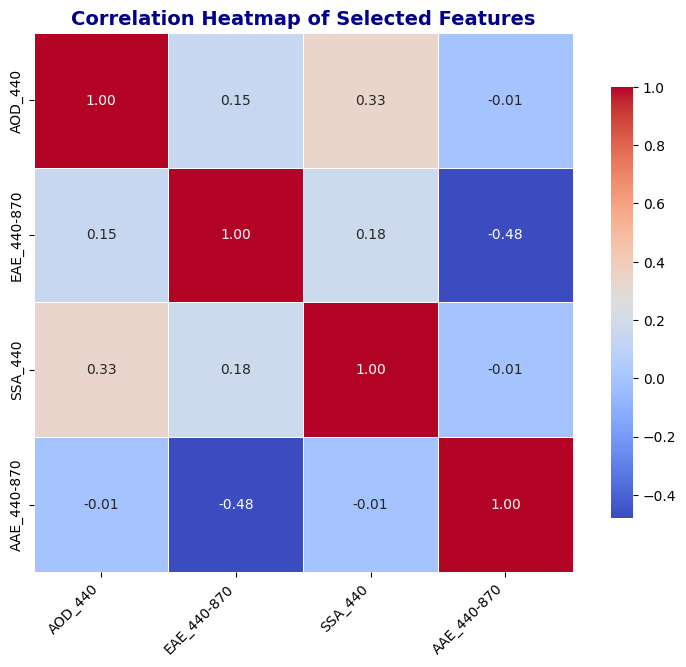

In [ ]:
#correlation heatmap
short_labels = {
    "AOD_Extinction-Total[440nm]": "AOD_440",
    "Extinction_Angstrom_Exponent_440-870nm-Total": "EAE_440-870",
    "Single_Scattering_Albedo[440nm]": "SSA_440",
    "Absorption_Angstrom_Exponent_440-870nm": "AAE_440-870"
}

corr_data = aerosol[selected_cols].rename(columns=short_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(corr_data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, square=True, cbar_kws={'shrink': 0.8})
plt.title("Correlation Heatmap of Selected Features", fontsize=14, fontweight="bold", color="darkblue")
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.show()


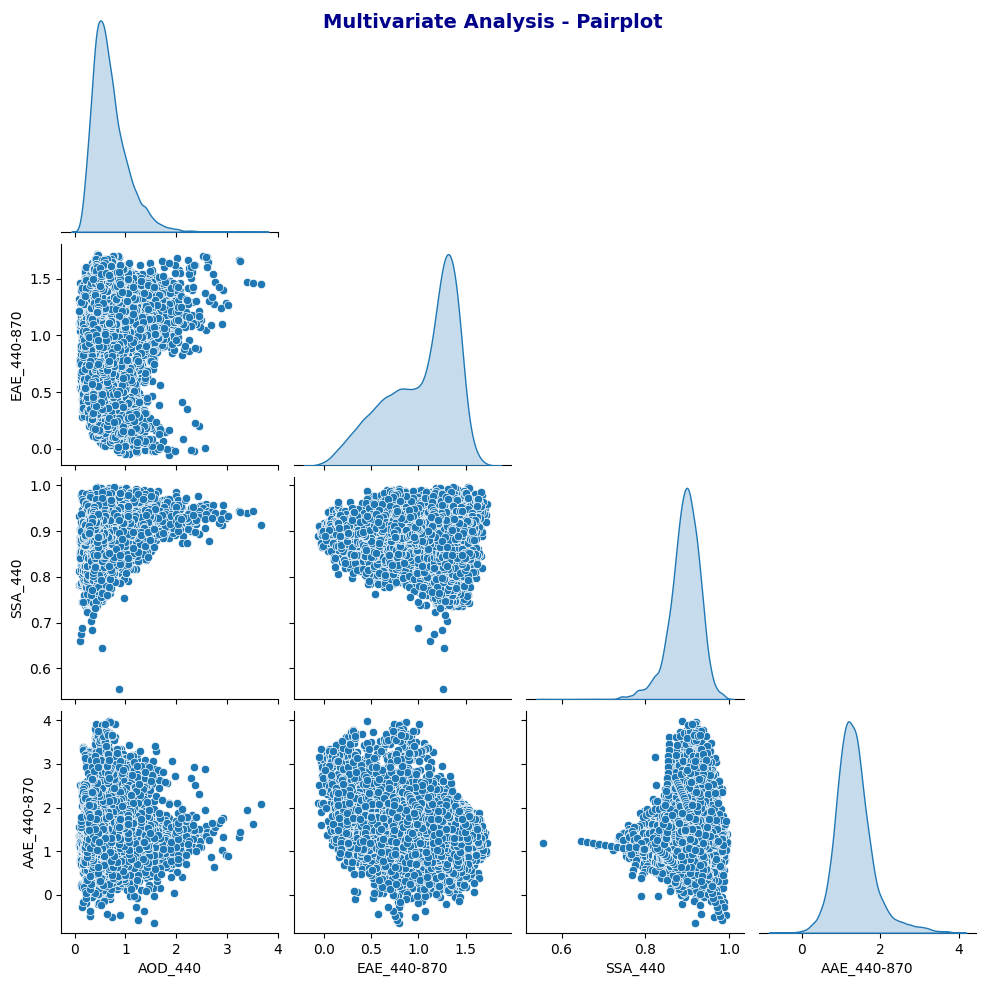

In [ ]:
# pairplot
#corr_data = aerosol[univariate_cols].rename(columns=short_labels)
pairplot = sns.pairplot(corr_data, diag_kind="kde", corner=True)
pairplot.fig.suptitle("Multivariate Analysis - Pairplot", fontsize=14, fontweight="bold", color="darkblue")

plt.show()

# Add calculated columns using Dubovik and King’s formulae and compute the differences with the provided data.

In [ ]:
# adding calculated data cols according to Dubovik and King provided formulae and differnce with provided data
# Calculate EAE
aerosol["Calculated_EAE"] = -np.log(aerosol["AOD_Extinction-Total[440nm]"] / aerosol["AOD_Extinction-Total[870nm]"]) / np.log(440 / 870)

# Difference in EAE
aerosol["EAE_Difference"] = aerosol["Extinction_Angstrom_Exponent_440-870nm-Total"] - aerosol["Calculated_EAE"]

# Calculate AAOD and their differences for different wavelengths
for wl in ['440nm', '675nm', '870nm', '1020nm']:
    aerosol[f'Calculated_AAOD[{wl}]'] = aerosol[f'AOD_Extinction-Total[{wl}]'] * (1 - aerosol[f'Single_Scattering_Albedo[{wl}]'])
    aerosol[f'AAOD_Difference[{wl}]'] = aerosol[f'Absorption_AOD[{wl}]'] - aerosol[f'Calculated_AAOD[{wl}]']

# Calculate AAE
aerosol["Calculated_AAE"] = (-np.log(aerosol["Calculated_AAOD[870nm]"]) + np.log(aerosol["Calculated_AAOD[440nm]"])) / np.log(440 / 870)

# Difference in AAE
aerosol["AAE_Difference"] = aerosol["Absorption_Angstrom_Exponent_440-870nm"] - aerosol["Calculated_AAE"]

In [ ]:
aerosol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19272 entries, 0 to 19271
Data columns (total 47 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Site                                          19272 non-null  object 
 1   Date(dd:mm:yyyy)                              19272 non-null  object 
 2   Time(hh:mm:ss)                                19272 non-null  object 
 3   Day_of_Year                                   19272 non-null  int64  
 4   Day_of_Year(Fraction)                         19272 non-null  float64
 5   AOD_Extinction-Total[440nm]                   19272 non-null  float64
 6   AOD_Extinction-Total[675nm]                   19272 non-null  float64
 7   AOD_Extinction-Total[870nm]                   19272 non-null  float64
 8   AOD_Extinction-Total[1020nm]                  19272 non-null  float64
 9   AOD_Extinction-Fine[440nm]                    19272 non-null 

In [ ]:
aerosol.isnull().sum()

Site                                            0
Date(dd:mm:yyyy)                                0
Time(hh:mm:ss)                                  0
Day_of_Year                                     0
Day_of_Year(Fraction)                           0
AOD_Extinction-Total[440nm]                     0
AOD_Extinction-Total[675nm]                     0
AOD_Extinction-Total[870nm]                     0
AOD_Extinction-Total[1020nm]                    0
AOD_Extinction-Fine[440nm]                      0
AOD_Extinction-Fine[675nm]                      0
AOD_Extinction-Fine[870nm]                      0
AOD_Extinction-Fine[1020nm]                     0
AOD_Extinction-Coarse[440nm]                    0
AOD_Extinction-Coarse[675nm]                    0
AOD_Extinction-Coarse[870nm]                    0
AOD_Extinction-Coarse[1020nm]                   0
Extinction_Angstrom_Exponent_440-870nm-Total    0
Single_Scattering_Albedo[440nm]                 0
Single_Scattering_Albedo[675nm]                 0
Single_Scattering_Albedo[870nm]                 0
Single_Scattering_Albedo[1020nm]                0
Absorption_AOD[440nm]                           0
Absorption_AOD[675nm]                           0
Absorption_AOD[870nm]                           0
Absorption_AOD[1020nm]                          0
Absorption_Angstrom_Exponent_440-870nm          0
Refractive_Index-Real_Part[440nm]               0
Refractive_Index-Real_Part[675nm]               0
Refractive_Index-Real_Part[870nm]               0
Refractive_Index-Real_Part[1020nm]              0
Refractive_Index-Imaginary_Part[440nm]          0
Refractive_Index-Imaginary_Part[675nm]          0
Refractive_Index-Imaginary_Part[870nm]          0
Refractive_Index-Imaginary_Part[1020nm]         0
Calculated_EAE                                  0
EAE_Difference                                  0
Calculated_AAOD[440nm]                          0
AAOD_Difference[440nm]                          0
Calculated_AAOD[675nm]                          0
AAOD_Difference[675nm]                          0
Calculated_AAOD[870nm]                          0
AAOD_Difference[870nm]                          0
Calculated_AAOD[1020nm]                         0
AAOD_Difference[1020nm]                         0
Calculated_AAE                                  0
AAE_Difference                                  0
dtype: int64

# Standardization and Normalization of Data

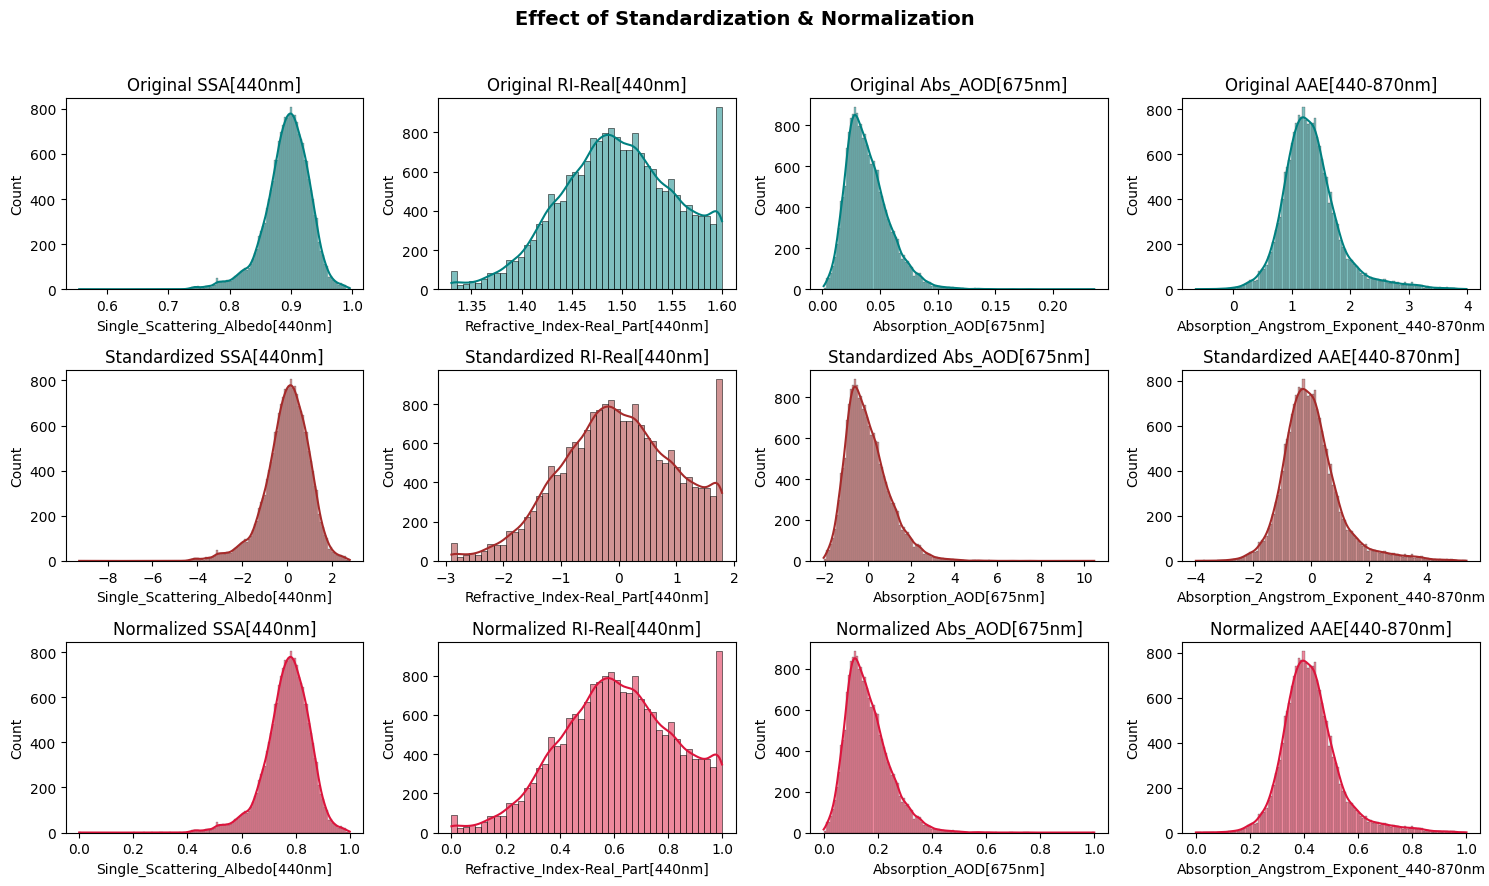

In [ ]:


# Select relevant numerical columns
selected_cols = [
    "Single_Scattering_Albedo[440nm]",
    "Refractive_Index-Real_Part[440nm]",
    "Absorption_AOD[675nm]",
    "Absorption_Angstrom_Exponent_440-870nm"
]

# Standardization (Z-score Scaling)
scaler_std = StandardScaler()
aerosol_std = aerosol.copy()
aerosol_std[selected_cols] = scaler_std.fit_transform(aerosol[selected_cols])

# Normalization (Min-Max Scaling)
scaler_minmax = MinMaxScaler()
aerosol_minmax = aerosol.copy()
aerosol_minmax[selected_cols] = scaler_minmax.fit_transform(aerosol[selected_cols])

# Plot Before and After Scaling
fig, axes = plt.subplots(3, len(selected_cols), figsize=(15, 9))
fig.suptitle("Effect of Standardization & Normalization", fontsize=14, fontweight="bold")

short_titles = ["SSA[440nm]", "RI-Real[440nm]", "Abs_AOD[675nm]", "AAE[440-870nm]"]

for idx, (col, short_col) in enumerate(zip(selected_cols, short_titles)):
    # Original Data
    sns.histplot(aerosol[col], kde=True, ax=axes[0, idx], color="teal")
    axes[0, idx].set_title(f"Original {short_col}")

    # Standardized Data
    sns.histplot(aerosol_std[col], kde=True, ax=axes[1, idx], color="brown")
    axes[1, idx].set_title(f"Standardized {short_col}")

    # Normalized Data
    sns.histplot(aerosol_minmax[col], kde=True, ax=axes[2, idx], color="crimson")
    axes[2, idx].set_title(f"Normalized {short_col}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



# Outlier


In [ ]:
from scipy.stats import skew

skew_values = aerosol.select_dtypes(include=['float64', 'int64']).apply(skew)
print(skew_values)

Day_of_Year                                     0.312365
Day_of_Year(Fraction)                           0.312473
AOD_Extinction-Total[440nm]                     1.445739
AOD_Extinction-Total[675nm]                     1.572409
AOD_Extinction-Total[870nm]                     1.939294
AOD_Extinction-Total[1020nm]                    2.317333
AOD_Extinction-Fine[440nm]                      1.670664
AOD_Extinction-Fine[675nm]                      1.968550
AOD_Extinction-Fine[870nm]                      2.145245
AOD_Extinction-Fine[1020nm]                     2.287594
AOD_Extinction-Coarse[440nm]                    2.823512
AOD_Extinction-Coarse[675nm]                    2.829182
AOD_Extinction-Coarse[870nm]                    2.818490
AOD_Extinction-Coarse[1020nm]                   2.793055
Extinction_Angstrom_Exponent_440-870nm-Total   -0.734705
Single_Scattering_Albedo[440nm]                -0.848558
Single_Scattering_Albedo[675nm]                -1.370140
Single_Scattering_Albedo[870nm]

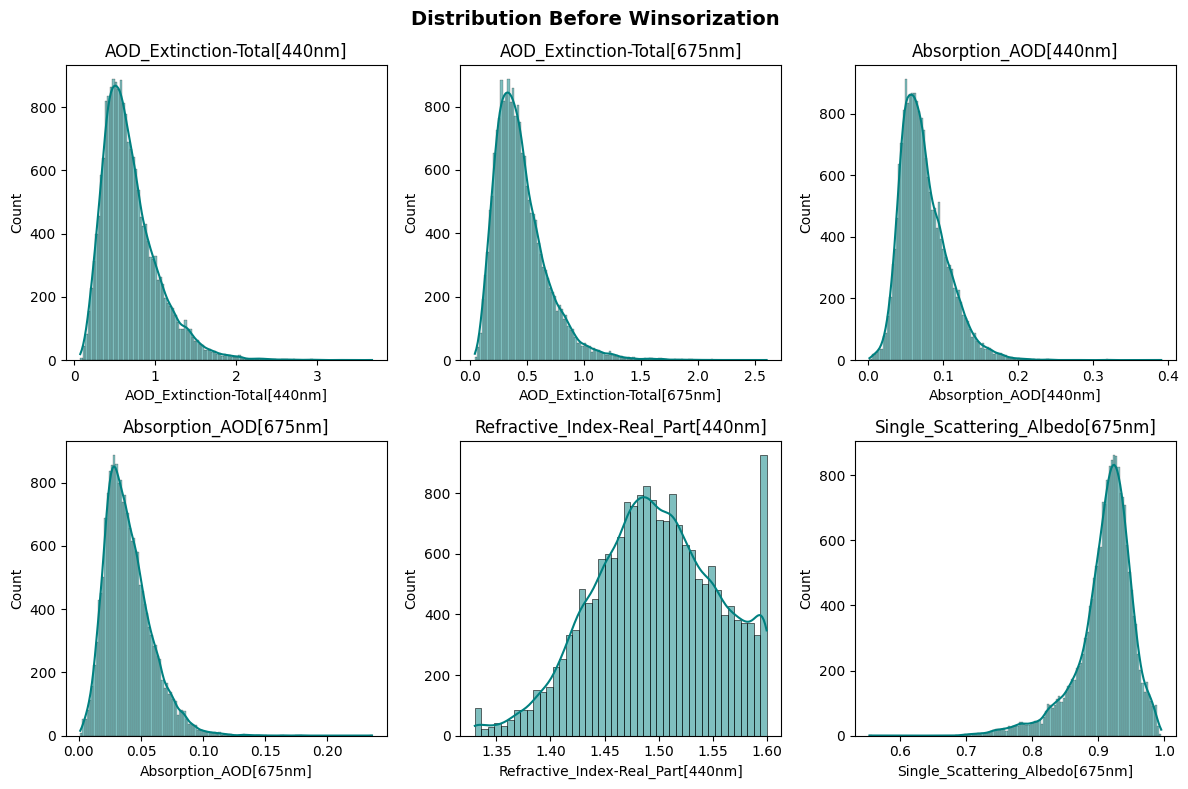

In [ ]:
#
sample_cols = [
    "AOD_Extinction-Total[440nm]", "AOD_Extinction-Total[675nm]",
    "Absorption_AOD[440nm]", "Absorption_AOD[675nm]",
    "Refractive_Index-Real_Part[440nm]", "Single_Scattering_Albedo[675nm]"
]


plt.figure(figsize=(12, 8))
plt.suptitle("Distribution Before Winsorization", fontsize=14, fontweight="bold")

for i, col in enumerate(sample_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(aerosol[col], kde=True, color="teal")
    plt.title(col)

plt.tight_layout()
plt.show()


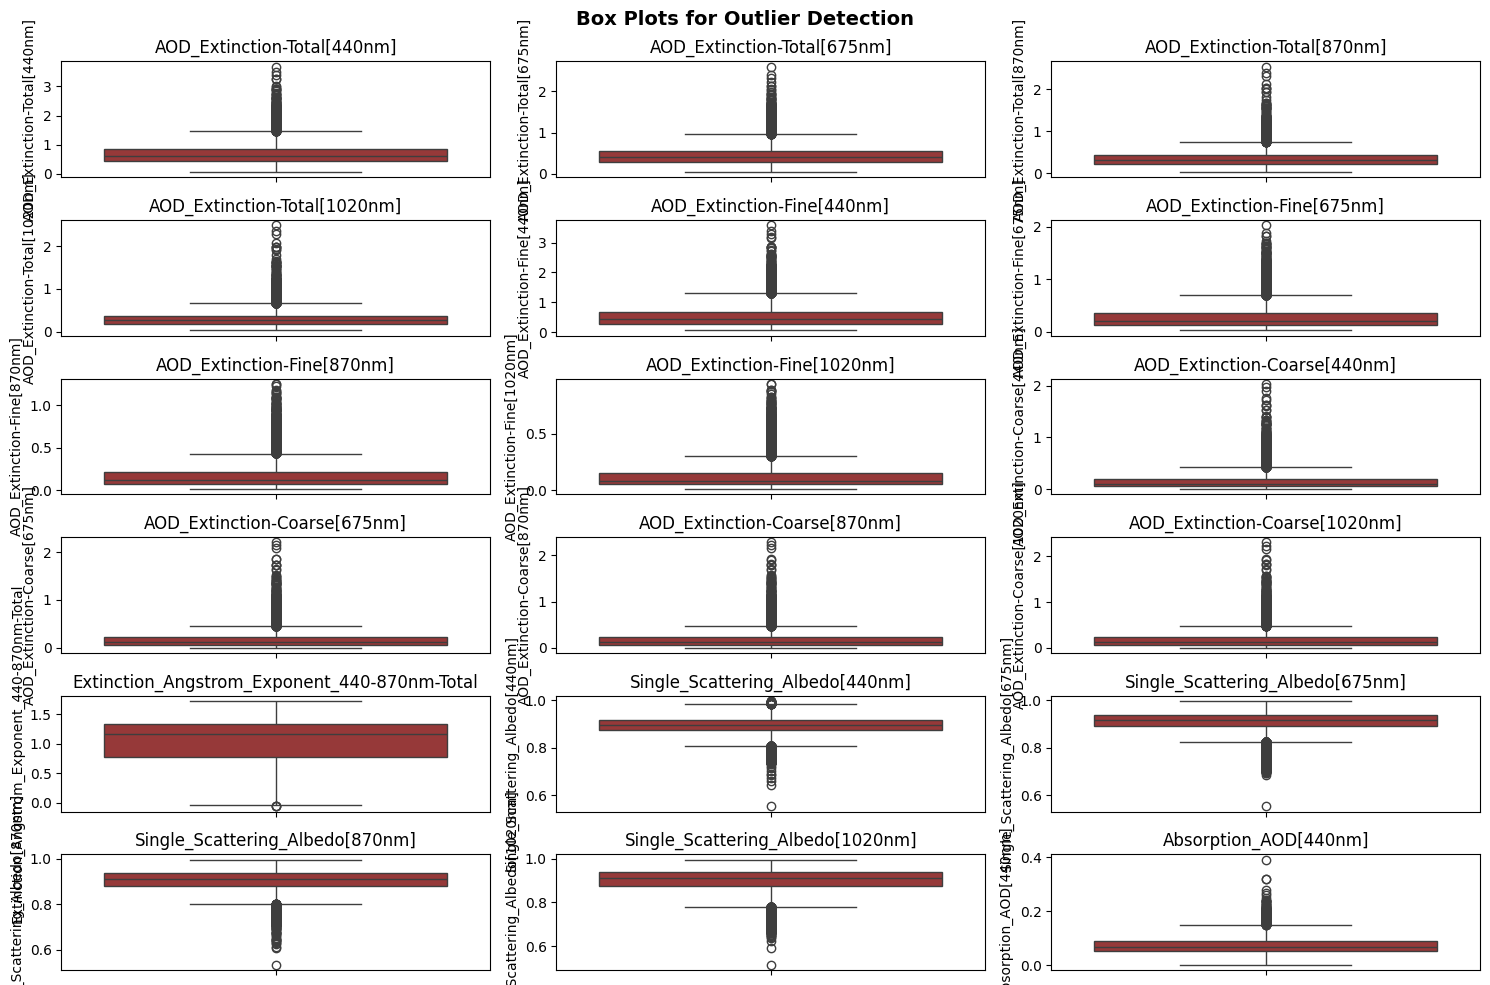

In [ ]:

num_cols = aerosol.select_dtypes(include=['float64', 'int64']).columns.drop(["Day_of_Year", "Day_of_Year(Fraction)"])


plt.figure(figsize=(15, 10))
plt.suptitle("Box Plots for Outlier Detection", fontsize=14, fontweight="bold")

for i, col in enumerate(num_cols[:18], 1):
    plt.subplot(6, 3, i)
    sns.boxplot(y=aerosol[col], color="brown")
    plt.title(col)

plt.tight_layout()
plt.show()

In [ ]:
# Copy original data to avoid modifying it
aerosol_iqr = aerosol.copy()

# Define numerical columns (excluding "Day_of_Year")
num_cols = aerosol.select_dtypes(include=['float64', 'int64']).columns.drop(["Day_of_Year", "Day_of_Year(Fraction)"])

# Apply IQR method for outlier handling
for col in num_cols:
    Q1 = aerosol[col].quantile(0.25)  # 25th percentile
    Q3 = aerosol[col].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile range

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers
    aerosol_iqr[col] = aerosol[col].clip(lower=lower_bound, upper=upper_bound)

<ipython-input-27-e4ae27dc9c18>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(short_labels, rotation=20, fontsize=12)  # Shortened names
<ipython-input-27-e4ae27dc9c18>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(short_labels, rotation=20, fontsize=12)  # Shortened names


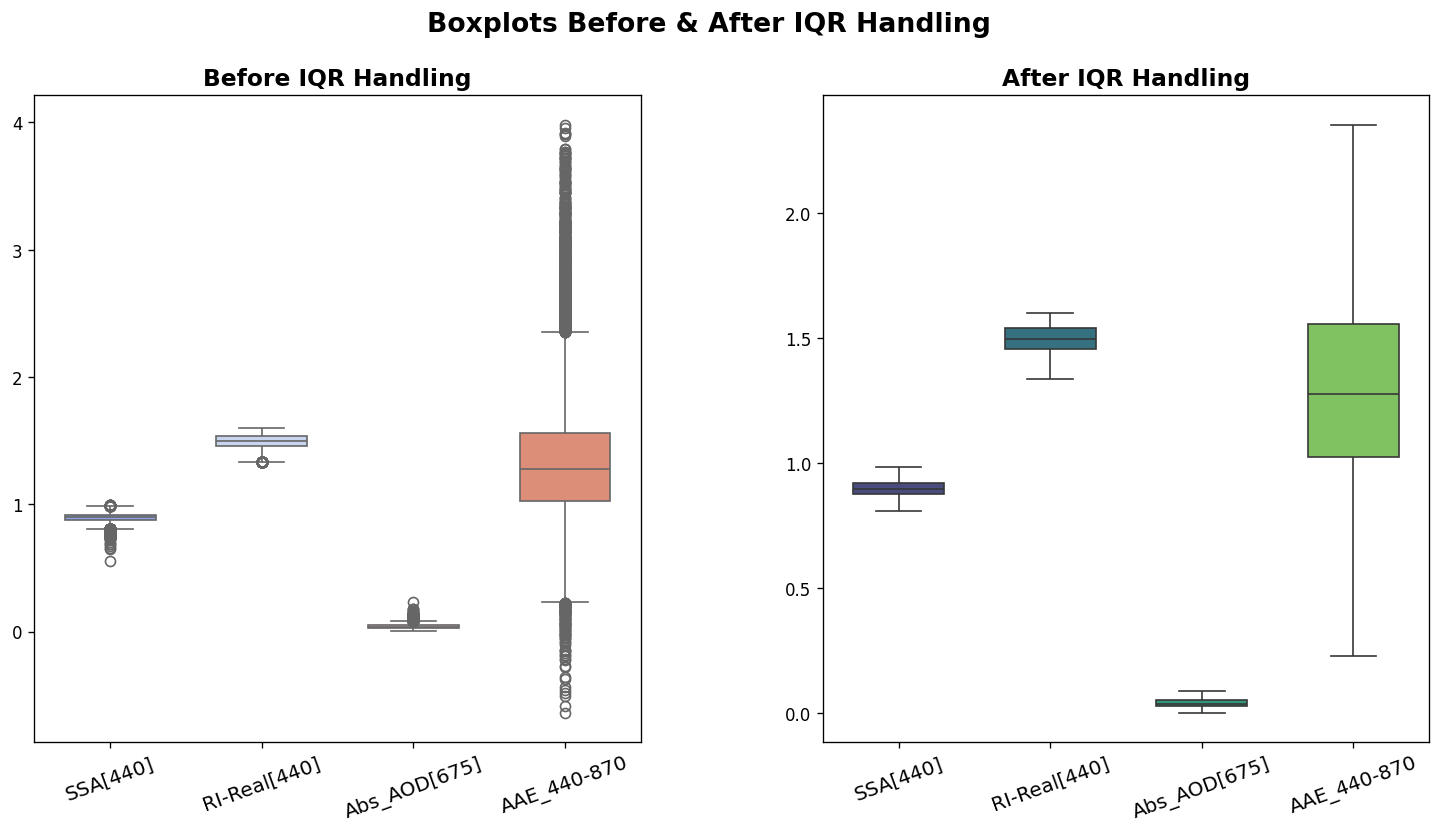

In [ ]:


# Shortened column names for better readability
short_labels = ["SSA[440]", "RI-Real[440]", "Abs_AOD[675]", "AAE_440-870"]

# Increase figure size for better visibility
fig, axes = plt.subplots(1, 2, figsize=(15, 7), dpi=120)
fig.suptitle("Boxplots Before & After IQR Handling", fontsize=16, fontweight="bold")

# Before IQR Handling
sns.boxplot(data=aerosol[selected_cols], ax=axes[0], palette="coolwarm", width=0.6, showfliers=True)
axes[0].set_title("Before IQR Handling", fontsize=14, fontweight="bold")
axes[0].set_xticklabels(short_labels, rotation=20, fontsize=12)  # Shortened names

# After IQR Handling
sns.boxplot(data=aerosol_iqr[selected_cols], ax=axes[1], palette="viridis", width=0.6, showfliers=True)
axes[1].set_title("After IQR Handling", fontsize=14, fontweight="bold")
axes[1].set_xticklabels(short_labels, rotation=20, fontsize=12)  # Shortened names

# Adjust layout to avoid overlapping
plt.subplots_adjust(wspace=0.3)
plt.show()


In [ ]:
aerosol = aerosol_iqr.copy()


# Frequency Distribution of Aerosol Optical Properties Fig 2

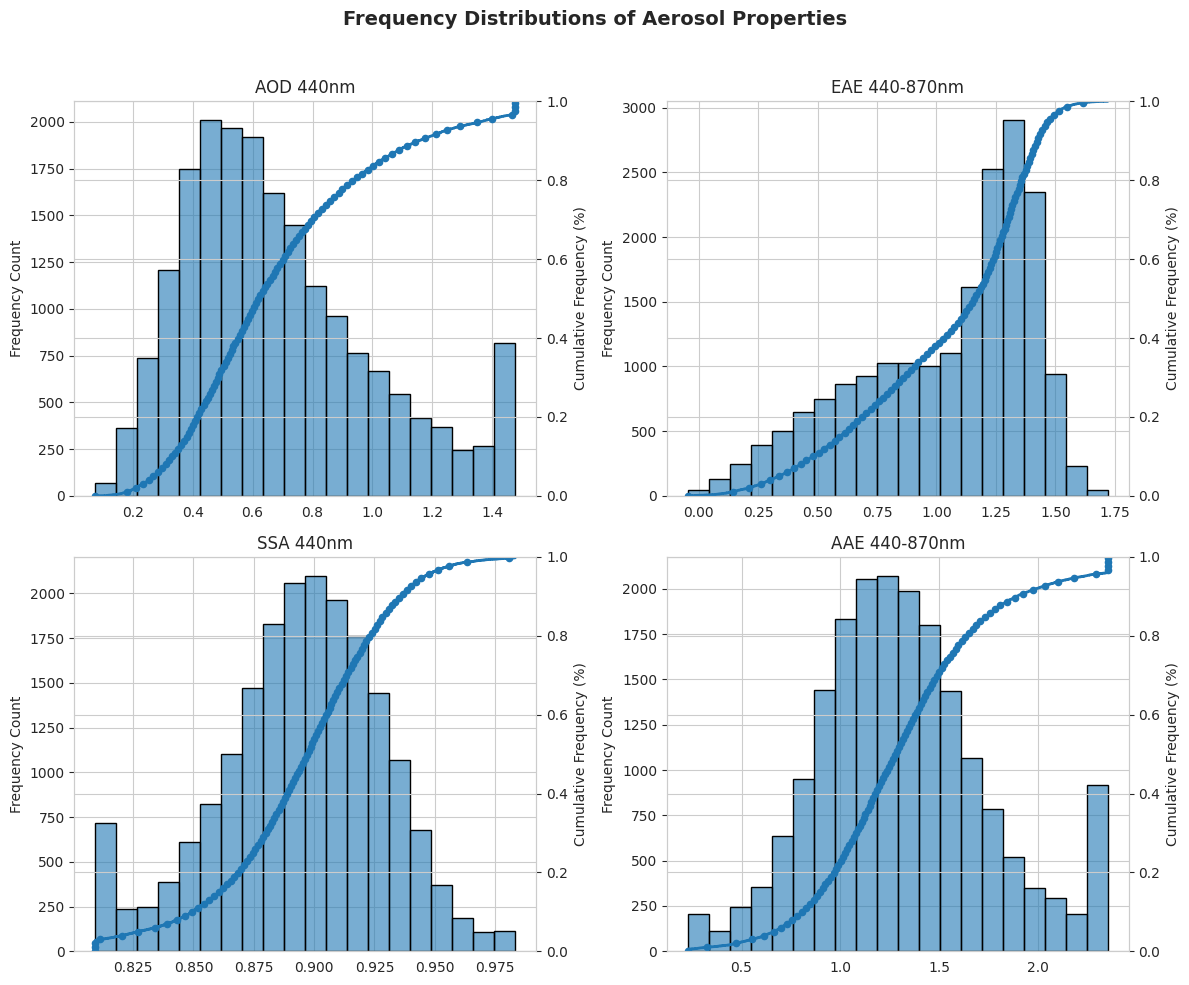

In [ ]:

# Set style
sns.set_style("whitegrid")

# Define the columns for plotting
columns = {
    "AOD 440nm": "AOD_Extinction-Total[440nm]",
    "EAE 440-870nm": "Extinction_Angstrom_Exponent_440-870nm-Total",
    "SSA 440nm": "Single_Scattering_Albedo[440nm]",
    "AAE 440-870nm": "Absorption_Angstrom_Exponent_440-870nm"
}

# Define figure and axes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Frequency Distributions of Aerosol Properties", fontsize=14, fontweight="bold")

# Iterate over columns and axes
for ax, (title, col) in zip(axes.flatten(), columns.items()):
    # Plot histogram with increased bins
    sns.histplot(aerosol[col], bins=20, kde=False, edgecolor="black", alpha=0.6, ax=ax)

    # Overlay cumulative distribution with spaced dots
    ax2 = ax.twinx()
    sorted_data = np.sort(aerosol[col].dropna())  # Sort values & drop NaN
    spacing_factor = max(1, len(sorted_data) // 100)  # Adjust spacing dynamically
    sns.ecdfplot(sorted_data, ax=ax2, linewidth=2)  # Smooth ECDF
    ax2.scatter(sorted_data[::spacing_factor], np.linspace(0, 1, len(sorted_data))[::spacing_factor], s=20)  # Adds spaced dots

    # Formatting
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("Frequency Count")
    ax2.set_ylabel("Cumulative Frequency (%)")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Fig. 3. Scatter plots of fine mode AODs, AAOD, EAE, AAE, SSA, and real refractive index.

In [ ]:
!pip install cartopy

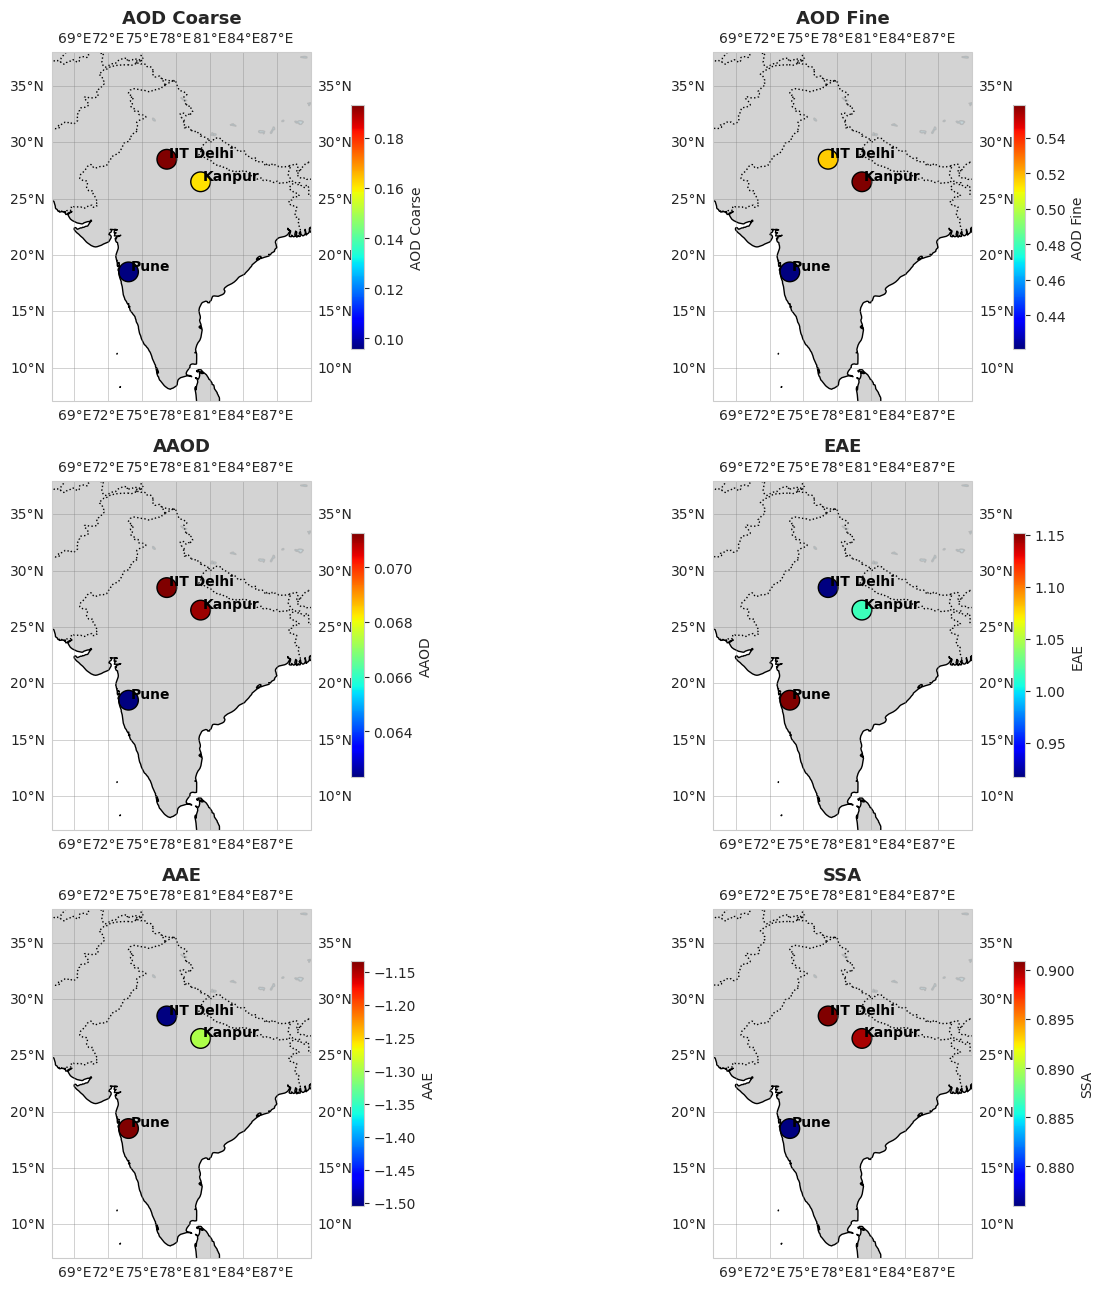

In [60]:

import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Site coordinates
site_coords = {
    'IIT_Delhi': (28.5, 77.2),
    'Kanpur': (26.5, 80.2),
    'Pune': (18.5, 73.8)
}

# Average aerosol parameter extraction
site_data = {}
for site in site_coords.keys():
    site_df = aerosol[aerosol['Site'] == site]
    site_data[site] = {
        'AOD_coarse': site_df['AOD_Extinction-Coarse[440nm]'].mean(),
        'AOD_fine': site_df['AOD_Extinction-Fine[440nm]'].mean(),
        'AAOD': site_df['Calculated_AAOD[440nm]'].mean(),
        'EAE': site_df['Calculated_EAE'].mean(),
        'AAE': site_df['Calculated_AAE'].mean(),
        'SSA': site_df['Single_Scattering_Albedo[440nm]'].mean(),
    }

# Convert to DataFrame
plot_df = pd.DataFrame(site_data).T
plot_df['Latitude'] = [site_coords[site][0] for site in plot_df.index]
plot_df['Longitude'] = [site_coords[site][1] for site in plot_df.index]

# Parameters and beautiful titles
params = ['AOD_coarse', 'AOD_fine', 'AAOD', 'EAE', 'AAE', 'SSA']
titles = [
    'AOD Coarse',
    'AOD Fine',
    'AAOD',
    'EAE',
    'AAE',
    'SSA'
]

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(15, 13), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

for i, param in enumerate(params):
    ax = axs[i]

    # Set map extent (India region)
    ax.set_extent([67, 90, 7, 38], crs=ccrs.PlateCarree())

    # Add features
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.LAKES, edgecolor='gray', facecolor='lightblue', alpha=0.3)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.5, color='gray', alpha=0.5)

    # Scatter points with color mapped to parameter value
    sc = ax.scatter(
        plot_df['Longitude'],
        plot_df['Latitude'],
        c=plot_df[param],
        cmap='jet',   # Feel free to try: 'viridis', 'coolwarm', 'jet', etc.
        s=200,
        edgecolors='black',
        vmin=plot_df[param].min(),
        vmax=plot_df[param].max()
    )

    # Site labels
    for idx, row in plot_df.iterrows():
        ax.text(row['Longitude'] + 0.2, row['Latitude'] + 0.2, idx.replace('_', ' '),
                fontsize=10, fontweight='bold', color='black')

    # Title for each subplot
    ax.set_title(titles[i], fontsize=13, weight='bold')

    # Colorbar with label
    cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.7, pad=0.05)
    cbar.set_label(f'{titles[i]}', fontsize=10)

# Overall title

plt.tight_layout()
plt.show()


# Spectral Classification Algo


In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE


# Feature Selection
features = aerosol[
    ['AOD_Extinction-Fine[440nm]',
     'Extinction_Angstrom_Exponent_440-870nm-Total',
     'Single_Scattering_Albedo[440nm]',
     'Absorption_Angstrom_Exponent_440-870nm',
     'Refractive_Index-Real_Part[440nm]']
]

# Standardize Features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Spectral Clustering (4 Clusters)
clustering = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', random_state=42)
labels = clustering.fit_predict(scaled_features)

# 4. Add Cluster Labels to DataFrame
aerosol['Aerosol_Cluster'] = labels

#  5. Inspect Cluster Centroids to Manually Map Types
cluster_stats = aerosol.groupby('Aerosol_Cluster')[
    ['AOD_Extinction-Fine[440nm]',
     'Extinction_Angstrom_Exponent_440-870nm-Total',
     'Single_Scattering_Albedo[440nm]',
     'Absorption_Angstrom_Exponent_440-870nm',
     'Refractive_Index-Real_Part[440nm]']
].mean().round(3)

print("Cluster-wise average feature values:\n")
print(cluster_stats)

# 6. Manually Map Clusters to Aerosol Types
label_mapping = {
    0: 'Biomass',
    1: 'Urban/Industrial',
    2: 'Dust',
    3: 'Mixed'
}
aerosol['Aerosol_Type'] = aerosol['Aerosol_Cluster'].map(label_mapping)





Cluster-wise average feature values:

                 AOD_Extinction-Fine[440nm]  \
Aerosol_Cluster                               
0                                     0.426   
1                                     1.013   
2                                     0.251   
3                                     0.359   

                 Extinction_Angstrom_Exponent_440-870nm-Total  \
Aerosol_Cluster                                                 
0                                                       1.063   
1                                                       1.295   
2                                                       0.421   
3                                                       1.101   

                 Single_Scattering_Albedo[440nm]  \
Aerosol_Cluster                                    
0                                          0.894   
1                                          0.922   
2                                          0.895   
3                           

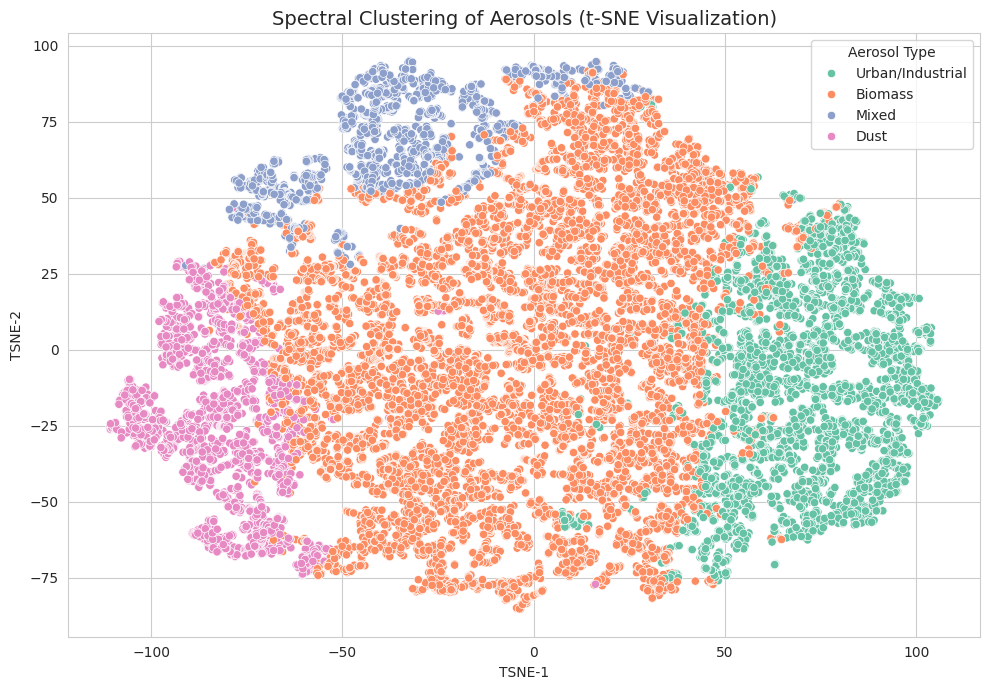

In [64]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(scaled_features)

aerosol['TSNE-1'] = tsne_result[:, 0]
aerosol['TSNE-2'] = tsne_result[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(data=aerosol, x='TSNE-1', y='TSNE-2', hue='Aerosol_Type', palette='Set2')
plt.title('Spectral Clustering of Aerosols (t-SNE Visualization)', fontsize=14)
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.legend(title='Aerosol Type')
plt.tight_layout()
plt.show()

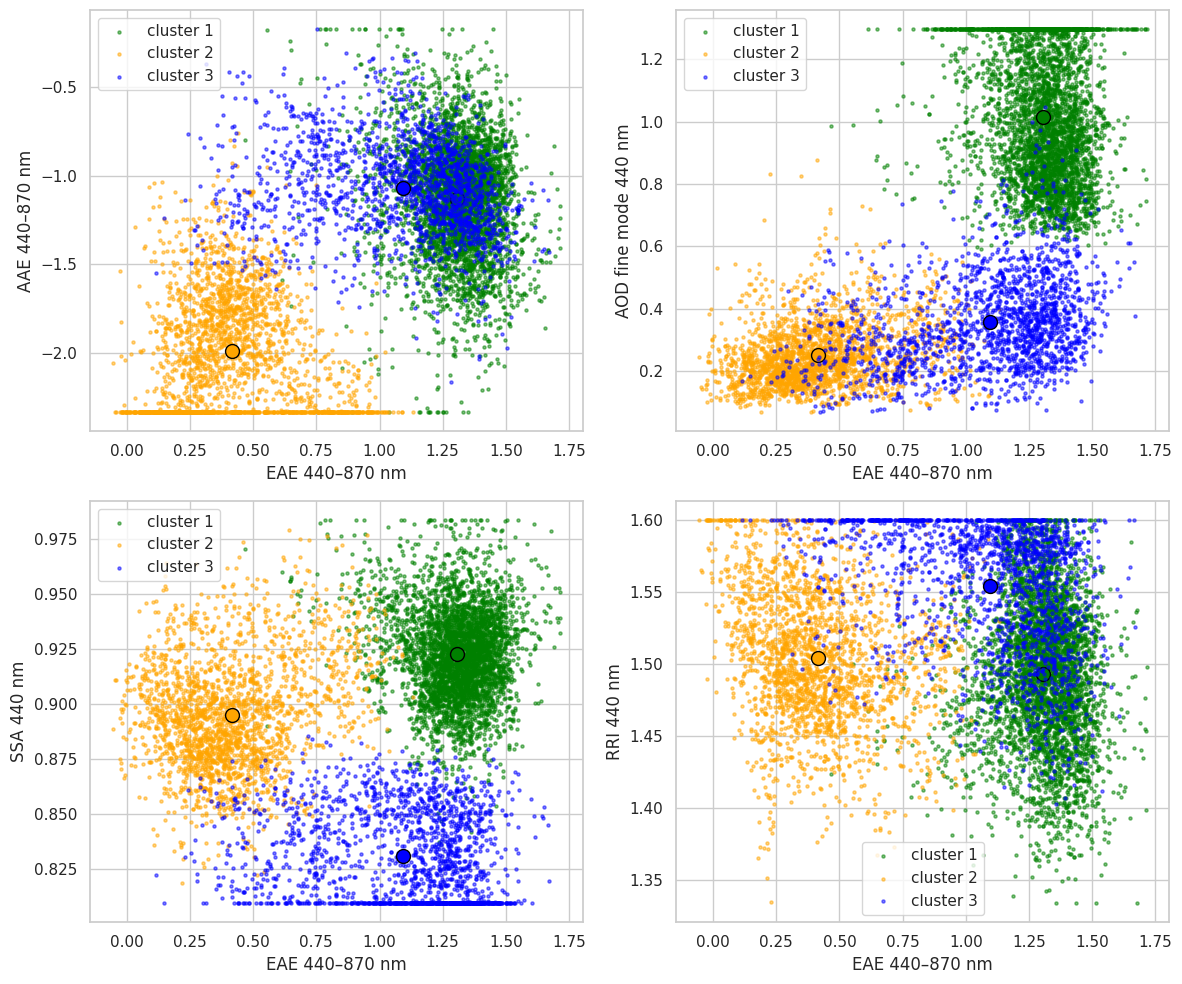

In [69]:


# Mapping for colors and labels
cluster_palette = {1: "green", 2: "orange", 3: "blue"}
cluster_labels = {1: "cluster 1", 2: "cluster 2", 3: "cluster 3"}

# Set seaborn style
sns.set(style="whitegrid")

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

# Plot settings: (x-axis, y-axis, y-label)
plot_data = [
    ("Calculated_EAE", "Calculated_AAE", "AAE 440–870 nm"),
    ("Calculated_EAE", "AOD_Extinction-Fine[440nm]", "AOD fine mode 440 nm"),
    ("Calculated_EAE", "Single_Scattering_Albedo[440nm]", "SSA 440 nm"),
    ("Calculated_EAE", "Refractive_Index-Real_Part[440nm]", "RRI 440 nm")
]

for i, (x_col, y_col, y_label) in enumerate(plot_data):
    ax = axs[i]
    for cluster_id, color in cluster_palette.items():
        cluster_data = aerosol[aerosol["Aerosol_Cluster"] == cluster_id]
        ax.scatter(
            cluster_data[x_col], cluster_data[y_col],
            s=5, color=color, alpha=0.5, label=cluster_labels[cluster_id]
        )
        # Plot centroids
        centroid_x = cluster_data[x_col].mean()
        centroid_y = cluster_data[y_col].mean()
        ax.scatter(
            centroid_x, centroid_y,
            color=color, edgecolor='black', s=100, marker='o'
        )
    ax.set_xlabel("EAE 440–870 nm")
    ax.set_ylabel(y_label)
    ax.legend()

plt.tight_layout()
plt.show()


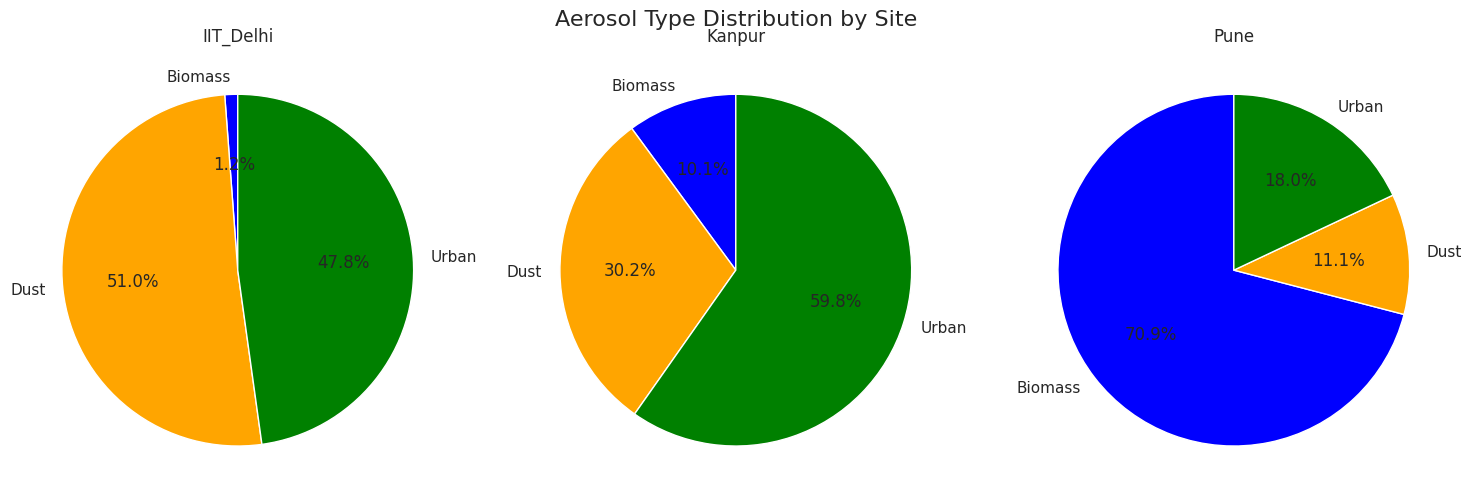

In [71]:
import matplotlib.pyplot as plt

# Ensure the mapping is applied
cluster_type_map = {
    1: "Urban",
    2: "Dust",
    3: "Biomass"
}
aerosol["Aerosol_Type_Name"] = aerosol["Aerosol_Cluster"].map(cluster_type_map)

# Count of each aerosol type per site
site_aerosol_counts = aerosol.groupby(["Site", "Aerosol_Type_Name"]).size().unstack(fill_value=0)

# Plot pie charts per site
n_sites = len(site_aerosol_counts)
n_cols = 3
n_rows = -(-n_sites // n_cols)  # Ceiling division

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axs = axs.flatten()

for i, (site, row) in enumerate(site_aerosol_counts.iterrows()):
    axs[i].pie(
        row,
        labels=row.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=["blue", "orange", "green"]
    )
    axs[i].set_title(site)

# Remove any empty subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.suptitle("Aerosol Type Distribution by Site", fontsize=16, y=1.02)
plt.show()


In [72]:
# Map clusters to aerosol type names
cluster_type_map = {
    1: "Urban",
    2: "Dust",
    3: "Biomass"
}
aerosol["Aerosol_Type_Name"] = aerosol["Aerosol_Cluster"].map(cluster_type_map)

# Count of each aerosol type per site
site_aerosol_counts = aerosol.groupby(["Site", "Aerosol_Type_Name"]).size().unstack(fill_value=0)

# Print the result
print(site_aerosol_counts)


Aerosol_Type_Name  Biomass  Dust  Urban
Site                                   
IIT_Delhi                7   302    283
Kanpur                 591  1768   3503
Pune                  1199   187    304
